In [1]:
import warnings
warnings.filterwarnings('ignore')
import torchvision
import torch
import pickle
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
data_dir= '../../processed_data'
data_dir= os.path.join(data_dir, 'after_aug')

features_train= os.path.join(data_dir, 'features_train')
features_validation= os.path.join(data_dir, 'features_validation')
features_test_final= os.path.join(data_dir, 'features_test')
labels_train= os.path.join(data_dir, 'labels_train')
labels_validation= os.path.join(data_dir, 'labels_validation')
labels_test_final= os.path.join(data_dir, 'labels_test')

x_train = pickle.load(open(features_train, 'rb'))
y_train = pickle.load(open(labels_train, 'rb'))

x_val = pickle.load(open(features_validation, 'rb'))
y_val = pickle.load(open(labels_validation, 'rb'))

x_test = pickle.load(open(features_test_final, 'rb'))
y_test = pickle.load(open(labels_test_final, 'rb'))

In [4]:
x_train= np.concatenate((x_train, x_val), axis=0)
y_train= np.concatenate((y_train, y_val), axis=0)

In [5]:
x_train = torch.tensor(x_train.transpose(0, 3, 1, 2), dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
x_test = torch.tensor(x_test.transpose(0, 3, 1, 2), dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [6]:
from torch.nn.functional import pad

def pad_to_size(x, target_size):
    _, _, h, w = x.shape
    ph = (target_size - h % target_size) % target_size
    pw = (target_size - w % target_size) % target_size
    padding = (0, pw, 0, ph)  # pad right and bottom
    return pad(x, padding, "constant", 0)

# Pad x_train to be divisible by 16
x_train = pad_to_size(x_train, 16)
print(f"Padded shape of x_train: {x_train.shape}")

x_test = pad_to_size(x_test, 16)
print(f"Padded shape of x_train: {x_test.shape}")

Padded shape of x_train: torch.Size([1597, 3, 304, 304])
Padded shape of x_train: torch.Size([31, 3, 304, 304])


In [7]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(train_dir: str, test_dir: str, transform: transforms.Compose, batch_size: int, num_workers: int = NUM_WORKERS):
    # Use ImageFolder to create dataset(s)
    train_data = x_train
    test_data = x_test

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_dataloader, test_dataloader, class_names

In [8]:
from torch.utils.data import DataLoader, TensorDataset
import torch

def create_dataloaders(x_train, y_train, x_test, y_test, batch_size):   
    # Create TensorDatasets
    train_dataset = TensorDataset(x_train, y_train)
    test_dataset = TensorDataset(x_test, y_test)

    # Create DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    class_names= ['comedones', 'cysts', 'nodules', 'papules', 'pustules']
    
    return train_dataloader, test_dataloader, class_names

In [9]:
# Create data Loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(x_train, y_train, x_test, y_test, batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1f30b070510>,
 ['comedones', 'cysts', 'nodules', 'papules', 'pustules'])

In [10]:
img_batch, labels= next(iter(train_dataloader))
img, label = img_batch[0], labels[0]
img.shape

torch.Size([3, 304, 304])

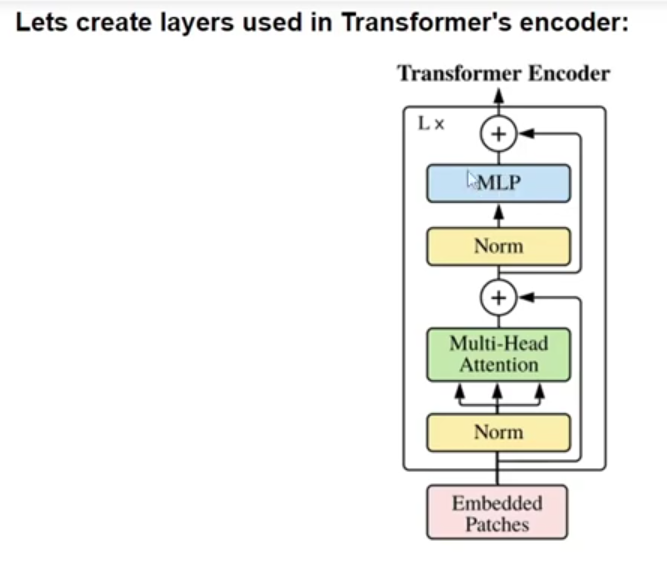


Step 1

Tasks:

1- tum an image into patches

2- flatten the patch feature naps into a single dimension

3- Convert the output into Desried output (flattened 2D patches): (#totPatches, 768) -> N×(P2.C) #Current shape: (1, 768, #totPatches)

In [11]:
# Define the PatchEmbedding class
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size, embedding_dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.proj = nn.Conv2d(in_channels, embedding_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # shape (B, C, H/P, W/P)
        x = x.flatten(2)  # shape (B, C, N)
        x = x.transpose(1, 2)  # shape (B, N, C)
        return x


In [12]:
import torch
from torch import nn

# Define a function to set seeds for reproducibility in PyTorch operations.
# This function is just there to set the random seeds
def set_seeds(seed=42):
    """Sets random seeds for reproducibility in PyTorch operations.
    
    Args:
        seed (int): Random seed to set. Defaults to 42.
    """
    torch.manual_seed(seed)           # Set the seed for CPU operations
    torch.cuda.manual_seed(seed)      # Set the seed for CUDA operations (GPU)

# Set the seeds
set_seeds()

# Create an instance of PatchEmbedding layer
patchify = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)

# Take a batch of images from the dataloader
images, _ = next(iter(train_dataloader))

# Check input image shape, ensure to maintain the batch dimension
single_image = images[0].unsqueeze(0)
print(f"Input image batch shape: {single_image.shape}")

# Pass the image through the patch embedding layer
patch_embedded_image = patchify(single_image)
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image batch shape: torch.Size([1, 3, 304, 304])
Output patch embedding shape: torch.Size([1, 361, 768])


#### Output patch embedding shape: torch.Size([1, 361, 768])

- we have one flattened layer and we have 361 patches in total for an image bcz 304/16 * 304/16 and 768 tokens once flattened

In [13]:
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.0695, -0.0125,  0.0316,  ..., -0.0246, -0.0702, -0.0012],
         [ 0.0019, -0.0812,  0.0164,  ..., -0.0294, -0.0373,  0.0082],
         [ 0.4699, -0.2658,  0.0909,  ..., -0.3271,  0.2530,  0.1137],
         ...,
         [ 0.7204, -0.0301, -0.3030,  ..., -0.1311,  0.2835, -0.1238],
         [ 0.7562, -0.0452, -0.2614,  ..., -0.1611,  0.2376, -0.1656],
         [ 0.4010,  0.0471, -0.3150,  ..., -0.2383,  0.0448, -0.3687]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 361, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [14]:
# import torch
# import torch.nn as nn

# # Define a function to set seeds for reproducibility
# def set_seeds(seed=42):
#     torch.manual_seed(seed)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed_all(seed)

# # Set seeds for reproducibility
# set_seeds()

# # Define the PatchEmbedding class
# class PatchEmbedding(nn.Module):
#     def __init__(self, in_channels, patch_size, embedding_dim):
#         super(PatchEmbedding, self).__init__()
#         self.patch_size = patch_size
#         self.embedding_dim = embedding_dim
#         self.proj = nn.Conv2d(in_channels, embedding_dim, kernel_size=patch_size, stride=patch_size)

#     def forward(self, x):
#         x = self.proj(x)  # shape (B, C, H/P, W/P)
#         x = x.flatten(2)  # shape (B, C, N)
#         x = x.transpose(1, 2)  # shape (B, N, C)
#         return x

# # Set the patch size
# patch_size = 16

# # Example input image tensor (simulated)
# image = torch.rand(3, 224, 224)  # Simulated image tensor (C, H, W)
# print(f"Image tensor shape: {image.shape}")

# # Get the height and width from the image dimensions
# height, width = image.shape[1], image.shape[2]

# # Add a batch dimension to the image tensor
# x = image.unsqueeze(0)
# print(f"Input image with batch dimension shape: {x.shape}")

# # Create a patch embedding layer
# patch_embedding_layer = PatchEmbedding(in_channels=3, patch_size=patch_size, embedding_dim=768)

# # Pass the image through the patch embedding layer
# patch_embedding = patch_embedding_layer(x)
# print(f"Patch embedding shape: {patch_embedding.shape}")

# # Create a class token embedding
# batch_size = patch_embedding.shape[0]
# embedding_dimension = patch_embedding.shape[-1]
# class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)
# print(f"Class token embedding shape: {class_token.shape}")

# # Prepend the class token embedding to the patch embedding
# patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
# print(f"Patch embedding with class token shape: {patch_embedding_with_class_token.shape}")

# # Create position embedding
# # Calculate the number of patches
# number_of_patches = int((height * width) / (patch_size ** 2))

# # Initialize the position embedding with learnable parameters
# position_embedding = nn.Parameter(torch.ones(1, number_of_patches + 1, embedding_dimension), requires_grad=True)
# print(f"Position embedding shape: {position_embedding.shape}")

# # Add position embedding to the patch embedding with class token
# # Combine the patch embeddings with the position embeddings
# patch_and_position_embedding = patch_embedding_with_class_token + position_embedding
# print(f"Patch and position embedding combined shape: {patch_and_position_embedding.shape}")

# # Print the combined patch and position embedding for verification
# print(patch_and_position_embedding)


- ([1, 196, 768]) we have 196 patches of size 768 after flattening

- so basically our patch embedding is an array of vectors consiting all the patches of an image flattened to 768 units. 768 is for this example.
- Each patch of an image is an individual input token.
- In the context of Vision Transformers (ViT) and similar architectures that use transformers for image processing, a class token is a special token that is appended to the sequence of patch embeddings before they are fed into the transformer encoder layers. This class token plays a crucial role in adapting transformers, originally designed for sequence-to-sequence tasks like language processing, for classification tasks in computer vision.

- Purpose of the Class - Token The class token is essentially a placeholder that accumulates information relevant to the classification task over the course of the transformer layers. It functions similarly to how the [CLS] token is used in models like BERT (Bidirectional Encoder Representations from Transformers) in natural language processing:

- Positional embeddings add information about the position of each element in the sequence to the input embeddings. This allows the model to understand the order of inputs, which is crucial for interpreting sequences correctly.



In [15]:
import torch
import torch.nn as nn

# Define a function to set seeds for reproducibility
def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Set seeds for reproducibility
set_seeds()

# Set the patch size
patch_size = 16

# Example input image tensor (simulated)
image = torch.rand(3, 304, 304)  # Simulated image tensor (C, H, W)
print(f"Image tensor shape: {image.shape}")

# Get the height and width from the image dimensions
height, width = image.shape[1], image.shape[2]

# Add a batch dimension to the image tensor
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# Create a patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3, patch_size=patch_size, embedding_dim=768)

# Pass the image through the patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# Create a class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.rand(batch_size, 1, embedding_dimension), requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

# Prepend the class token embedding to the patch embedding
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_with_class_token.shape}")

# Create position embedding
# Calculate the number of patches
number_of_patches = int((height * width) / (patch_size ** 2))

# Initialize the position embedding with learnable parameters
position_embedding = nn.Parameter(torch.rand(1, number_of_patches + 1, embedding_dimension), requires_grad=True)
print(f"Position embedding shape: {position_embedding.shape}")

# Add position embedding to the patch embedding with class token
# Combine the patch embeddings with the position embeddings
patch_and_position_embedding = patch_embedding_with_class_token + position_embedding
print(f"Patch and position embedding combined shape: {patch_and_position_embedding.shape}")

# Print the combined patch and position embedding for verification
print(patch_and_position_embedding)


Image tensor shape: torch.Size([3, 304, 304])
Input image with batch dimension shape: torch.Size([1, 3, 304, 304])
Patch embedding shape: torch.Size([1, 361, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 362, 768])
Position embedding shape: torch.Size([1, 362, 768])
Patch and position embedding combined shape: torch.Size([1, 362, 768])
tensor([[[ 1.5816,  1.3908,  1.5234,  ...,  0.5632,  1.4220,  0.3943],
         [ 0.7882,  0.2612,  0.5579,  ...,  0.5635, -0.2103,  0.6419],
         [ 0.3552,  0.6530,  0.7099,  ...,  0.9554,  0.2919,  0.2340],
         ...,
         [-0.3255,  0.8407, -0.1210,  ...,  0.1563,  0.4747,  0.7927],
         [ 0.8822,  1.0388,  0.1061,  ..., -0.1977,  0.4225,  0.1421],
         [ 0.1646,  0.1217,  0.0213,  ...,  0.3782,  0.4300,  0.0891]]],
       grad_fn=<AddBackward0>)


- Image tensor shape: torch.Size([3, 224, 224])

- Input image with batch dimension shape: torch.Size([1, 3, 361, 361])
- Patch embedding shape: torch.Size([1, 361, 768]) -> we are adding 361 ones 768  times
- Class token embedding shape: torch.Size([1, 1, 768]) -> we are adding 1 one 768 times 
- Patch embedding with class token shape: torch.Size([1, 362, 768])
- Position embedding shape: torch.Size([1, 362, 768])
- Patch and position embedding combined shape: torch.Size([1, 362, 768])
- tensor([[[ 1.5816,  1.3908,  1.5234,  ...,  0.5632,  1.4220,  0.3943],
         [ 0.7882,  0.2612,  0.5579,  ...,  0.5635, -0.2103,  0.6419],
         [ 0.3552,  0.6530,  0.7099,  ...,  0.9554,  0.2919,  0.2340],
         ...,
         [-0.3255,  0.8407, -0.1210,  ...,  0.1563,  0.4747,  0.7927],
         [ 0.8822,  1.0388,  0.1061,  ..., -0.1977,  0.4225,  0.1421],
         [ 0.1646,  0.1217,  0.0213,  ...,  0.3782,  0.4300,  0.0891]]],
       grad_fn=<AddBackward0>)

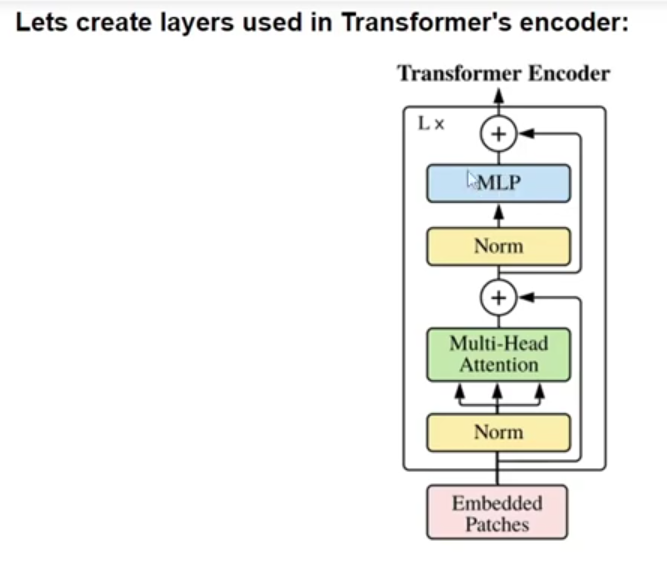

In [16]:
import torch
import torch.nn as nn

class MultiheadSelfAttentionBlock(nn.Module):
    """
    Creates a multi-head self-attention block ("MSA block").
    
    Attributes:
        embedding_dim (int): The size of the input feature dimension.
        num_heads (int): The number of attention heads. we are using 12 as per the original paper
        attn_dropout (float): Dropout rate applied to the attention scores. by default 0
    """
    def __init__(self, embedding_dim=768, num_heads=12, attn_dropout=0.0):
        """
        Initializes the MultiheadSelfAttentionBlock with specified dimensions and dropout.
        
        Args:
            embedding_dim (int): The dimensionality of the input features (default: 768).
            num_heads (int): The number of attention heads (default: 12).
            attn_dropout (float): The dropout rate for attention (default: 0.0).
        """
        super(MultiheadSelfAttentionBlock, self).__init__()
        
        # Normalization layer (Layer Normalization)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim) #We are creating the normalization layer
        
        # Multi-Head Attention Layer
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=embedding_dim, #768
            num_heads=num_heads, #12
            dropout=attn_dropout, #by def 0
            batch_first=True  # Specifies that the input tensors are provided as (batch, seq, feature)
        )

    #A forward methd to passs data throug layers
    def forward(self, x):
        """
        Forward pass for the MultiheadSelfAttentionBlock.
        
        Args:
            x (Tensor): The input tensor of shape (batch_size, sequence_length, embedding_dim).
        
        Returns:
            Tensor: The output tensor after self-attention, of the same shape as input.
        """
        # Apply layer normalization
        x_norm = self.layer_norm(x)
        
        # Apply the multi-head attention mechanism
        # - 'query', 'key', 'value' are all the same for self-attention
        # - 'need_weights=False' signifies that we do not need the attention weights returned
        attn_output, _ = self.multihead_attn(query=x_norm, key=x_norm, value=x_norm, need_weights=False) 
        #For every patch or 1d vector we will have a query key and value. 
        
        return attn_output


- Query: The query is a representation of a word or token in the input sequence. In the case of Vision Transformers (ViT), the input tokens are patches extracted from an image. Each patch is represented by a query vector. The query vector is multiplied with the key vectors to determine the importance of different patches relative to each other.
- Key: The key is another representation of a word or token in the input sequence. Similar to queries, each patch in ViT is represented by a key vector. The key vectors are used to calculate the attention scores between different patches. The key vectors essentially provide information about the content of each patch.
- Value: The value is the information associated with each key. In the context of ViT, the value vectors represent the features of each patch. These features are combined based on the attention scores calculated using the query and key vectors. The output of the self-attention mechanism is a weighted sum of the value vectors, where the weights are determined by the attention scores.

In [17]:
import torch.nn as nn

class MLPBlock(nn.Module):
    """Creates a layer-normalized multilayer perceptron block (MLP block) as described in the paper."""
    
    def __init__(self, embedding_dim: int = 76, mlp_size: int = 3072, dropout: float = 0.1):
        """
        Initializes the MLPBlock with the specified hyperparameters.
        
        Args:
        - embedding_dim (int): Hidden size D from Table 1 for ViT-Base.
        - mlp_size (int): MLP size from Table 1 for ViT-Base.
        - dropout (float): Dropout rate from Table 3 for ViT-Base.
        """
        super().__init__()
        
        # Create the Layer Normalization (LN) layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # Create the Multilayer Perceptron (MLP) network layer(s). Here we have created a small n/w. a small multi layer preceptron network
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),  # Apply GELU activation function
            nn.Dropout(p=dropout),  # Apply dropout
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),  # Map back to embedding_dim
            nn.Dropout(p=dropout)  # Apply dropout
        )

    #Forward funciton to pass the data through the layers
    def forward(self, x):
        """
        Passes the input data through the layers of the MLPBlock.
        
        Args:
        - x (torch.Tensor): Input tensor
        
        Returns:
        - torch.Tensor: Output tensor
        """
        x = self.layer_norm(x)  # Apply layer normalization
        x = self.mlp(x)  # Pass through MLP layers
        return x


In [18]:
import torch.nn as nn

class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block. The entire block. """

    def __init__(self, 
                 embedding_dim: int = 768, 
                 num_heads: int = 12, #Heads from orig paper
                 mlp_size: int = 3072,
                 mlp_dropout: float = 0.1, 
                 attn_dropout: float = 0):
        """
        Initializes the TransformerEncoderBlock with the specified hyperparameters.
        
        Args:
        - embedding_dim (int): Hidden size D from Table 1 for ViT-Base.
        - num_heads (int): Number of attention heads for ViT-Base.
        - mlp_size (int): MLP size for ViT-Base.
        - mlp_dropout (float): Amount of dropout for dense Layers
        - attn_dropout (float): Amount of dropout for attention Layers.
        """
        super().__init__()

        # Create Multihead Self-Attention (MSA) block
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # Create MLP block
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                  mlp_size=mlp_size,
                                  dropout=mlp_dropout)

    #To pass the data from the layers.
    def forward(self, x):
        """
        Passes the input data through the layers of the TransformerEncoderBlock.
        
        Args:
        - x (torch.Tensor): Input tensor
        
        Returns:
        - torch.Tensor: Output tensor
        """
        # Apply Multihead Self-Attention (MSA) block with residual connection
        x_res_msa = self.msa_block(x) + x

        # Apply MLP block with residual connection
        x_res_mlp = self.mlp_block(x_res_msa) + x_res_msa

        return x_res_mlp


In [19]:
# Instantiate the TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Import the summary function from torchinfo
from torchinfo import summary

# Print an input and output summary of the Transformer Encoder block
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768),  # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [20]:
import torch
import torch.nn as nn

class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""

    def __init__(self, 
                 img_size: int = 304, 
                 in_channels: int = 3, 
                 patch_size: int = 16,
                 num_transformer_layers: int = 12, 
                 embedding_dim: int = 768, 
                 mlp_size: int = 3072,
                 num_heads: int = 12, 
                 attn_dropout: float = 0, 
                 mlp_dropout: float = 0.1,
                 embedding_dropout: float = 0.1, 
                 num_classes: int = 1000):
        """
        Initializes the ViT model with the specified hyperparameters.
        
        Args:
        - img_size (int): Training resolution from Table 3 in ViT paper.
        - in_channels (int): Number of channels in input image.
        - patch_size (int): Patch size.
        - num_transformer_layers (int): Number of layers from Table 1 for ViT-Base.
        - embedding_dim (int): Hidden size D from Table 1 for ViT-Base.
        - mlp_size (int): MLP size from Table 1 for ViT-Base.
        - num_heads (int): Number of attention heads from Table 1 for ViT-Base.
        - attn_dropout (float): Dropout for attention projection.
        - mlp_dropout (float): Dropout for dense/MLP Layers.
        - embedding_dropout (float): Dropout for patch and position embeddings.
        - num_classes (int): Number of output classes.
        """
        super().__init__()

        # Check if image size is divisible by patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}"

        # Calculate number of patches (height * width / patch^2)
        self.num_patches = (img_size * img_size) // (patch_size ** 2) # to see tot num of patches

        # Create learnable class embedding
        self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim), requires_grad=True) #we use rand. we start with some random value in DL.

        # Create learnable position embedding
        self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embedding_dim), requires_grad=True) #This decides which patch comes first and which comes last.

        # Create embedding dropout
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim)

        # Create transformer encoder blocks. we are stacking Transformer encoder blocks using Sequential function
        self.transformer_encoder = nn.Sequential(
            *[TransformerEncoderBlock(embedding_dim=embedding_dim, num_heads=num_heads,
                                      mlp_size=mlp_size, mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)]
        )

        # Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
        )

    def forward(self, x):
        """
        Passes the input data through the layers of the ViT model.
        
        Args:
        - x (torch.Tensor): Input tensor
        
        Returns:
        - torch.Tensor: Output tensor
        """
        # Get batch size
        batch_size = x.shape[0]

        # Create class token embedding and expand it to match the batch size
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        # Create patch embedding
        x = self.patch_embedding(x)

        # Concatenate class embedding and patch embedding
        x = torch.cat((class_token, x), dim=1)

        # Add position embedding to patch embedding
        x = self.position_embedding + x

        # Run embedding dropout
        x = self.embedding_dropout(x)

        # Pass patch, position, and class embedding through transformer encoder layers
        x = self.transformer_encoder(x)

        # Put 0 index Logit through classifier
        x = self.classifier(x[:, 0])

        return x

# Training the model

In [21]:
vit= ViT(num_classes= len(class_names))

In [22]:
from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(
    params=vit.parameters(),
    lr=3e-3,  # Base LR from Table 3 for ViT - ImageNet-1k
    betas=(0.9, 0.999),  # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
    weight_decay=0.3  # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT
)

# Setup the Loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2485 | train_acc: 0.2261 | test_loss: 1.6000 | test_acc: 0.2258
Epoch: 2 | train_loss: 1.6411 | train_acc: 0.2180 | test_loss: 1.6384 | test_acc: 0.2258
Epoch: 3 | train_loss: 1.6467 | train_acc: 0.2368 | test_loss: 1.5596 | test_acc: 0.2903
Epoch: 4 | train_loss: 1.6321 | train_acc: 0.1978 | test_loss: 1.5975 | test_acc: 0.2903
Epoch: 5 | train_loss: 1.6132 | train_acc: 0.2371 | test_loss: 1.5666 | test_acc: 0.2581
Epoch: 6 | train_loss: 1.6089 | train_acc: 0.2284 | test_loss: 1.5438 | test_acc: 0.2903
Epoch: 7 | train_loss: 1.5990 | train_acc: 0.2386 | test_loss: 1.5717 | test_acc: 0.2581
Epoch: 8 | train_loss: 1.6089 | train_acc: 0.2191 | test_loss: 1.5756 | test_acc: 0.2903
Epoch: 9 | train_loss: 1.6020 | train_acc: 0.2365 | test_loss: 1.5704 | test_acc: 0.2903
Epoch: 10 | train_loss: 1.6012 | train_acc: 0.2412 | test_loss: 1.5710 | test_acc: 0.2903


In [27]:
final_train_accuracy = results['train_acc'][-1]
final_val_accuracy = results['test_acc'][-1]
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

Final Training Accuracy: 0.2412
Final Validation Accuracy: 0.2903


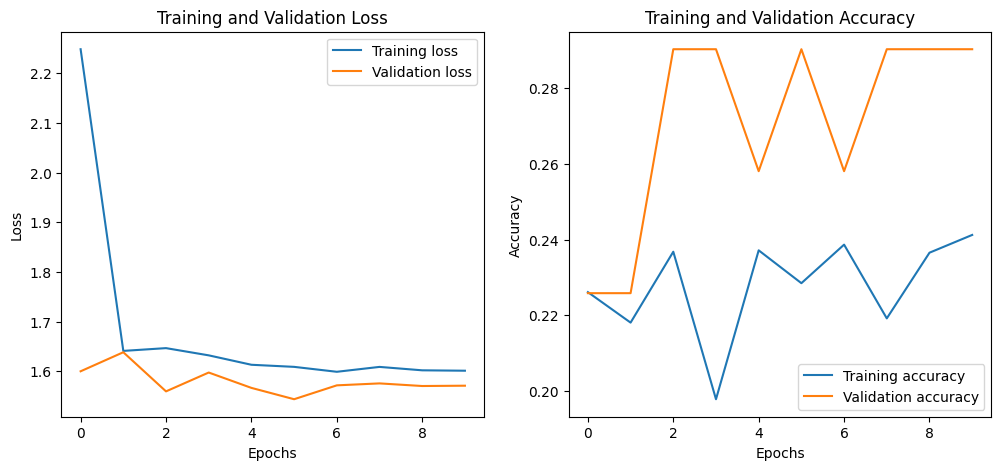

In [24]:
import matplotlib.pyplot as plt

def plot_training_results(results):
    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(results['train_loss'], label='Training loss')
    plt.plot(results['test_loss'], label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(results['train_acc'], label='Training accuracy')
    plt.plot(results['test_acc'], label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_results(results)

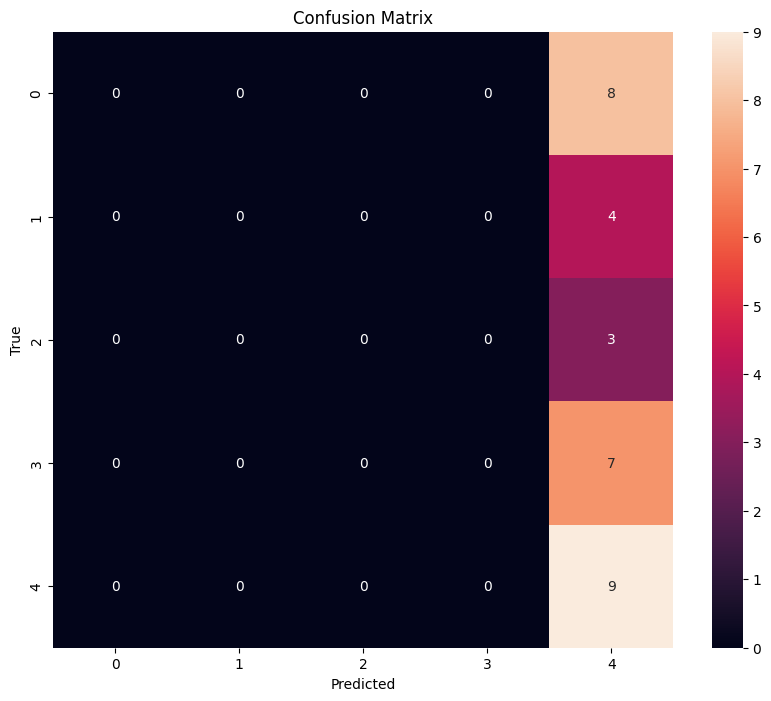

In [25]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Assuming test_dataloader is your validation set
predictions, labels = evaluate_model(vit, test_dataloader, device)

def plot_confusion_matrix(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(labels, predictions)


In [26]:
def print_classification_report(labels, predictions):
    report = classification_report(labels, predictions)
    print(report)

print_classification_report(labels, predictions)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         7
           4       0.29      1.00      0.45         9

    accuracy                           0.29        31
   macro avg       0.06      0.20      0.09        31
weighted avg       0.08      0.29      0.13        31

